In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import stan_jupyter as stan
import arviz as az
from PIL import Image
import numpy as np
from utils.glaph import pairplot

import statsmodels.api as sm
from matplotlib.figure import figaspect
from matplotlib import gridspec

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50)

## 11.3 ゼロ過剰ポアソン分布

この節では、ある飲食店への来店回数をアンケートで取得した架空データを扱う。

In [50]:
df = pd.read_csv("./data/data-ZIP.txt")
df.head()

,Sex,Sake,Age,Y
0,0,1,18,5
1,1,0,18,2
2,1,1,18,1
3,0,0,19,3
4,0,0,19,5


In [51]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Sex     200 non-null    int64
 1   Sake    200 non-null    int64
 2   Age     200 non-null    int64
 3   Y       200 non-null    int64
dtypes: int64(4)
memory usage: 6.4 KB


In [52]:
df.describe()

,Sex,Sake,Age,Y
count,200.000000,200.000000,200.000000,200.000000
mean,0.390000,0.305000,36.725000,4.195000
std,0.488974,0.461563,10.413529,4.064428
min,0.000000,0.000000,18.000000,0.000000
25%,0.000000,0.000000,28.000000,0.000000
50%,0.000000,0.000000,36.000000,4.000000
75%,1.000000,1.000000,45.250000,7.000000
max,1.000000,1.000000,55.000000,17.000000


- sex : 0 = 男、1 = 女
- Sake : 0 = 飲まない、1 = 飲む
- Age : 年齢
- Y : 来店回数（応答変数）

純粋に重回帰分析を実行してみる。

In [54]:
# 目的変数(Y)
Y = df['Y'].values
 
# 説明変数(X)
X = df.iloc[:, :-1].values
X = sm.add_constant(X)
print(X[:5])

# モデルの設定(OLS：最小二乗法を指定)
model = sm.OLS(Y, X)
 
# 回帰分析の実行
results = model.fit()

results.summary()

[[ 1.  0.  1. 18.]
 [ 1.  1.  0. 18.]
 [ 1.  1.  1. 18.]
 [ 1.  0.  0. 19.]
 [ 1.  0.  0. 19.]]


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.143
Model:                            OLS   Adj. R-squared:                  0.130
Method:                 Least Squares   F-statistic:                     10.91
Date:                Sun, 31 Jul 2022   Prob (F-statistic):           1.16e-06
Time:                        01:27:38   Log-Likelihood:                -548.29
No. Observations:                 200   AIC:                             1105.
Df Residuals:                     196   BIC:                             1118.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.2040      1.018      2.165      0.032       0.197       4.211
x1            -1.3228      0.551     -2.402      0.017      -2.409      -0.237
x2             2.6568      0.585      4.538      0.000       1.502       3.811
x3             0.0462      0.026      1.783      0.076      -0.005       0.097
==============================================================================
Omnibus:                       12.268   Durbin-Watson:                   2.075
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               11.891
Skew:                           0.544   Prob(JB):                      0.00262
Kurtosis:                       2.507   Cond. No.                         147.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- 「男性でお酒を飲んで年齢が高い人の来店回数が多そうだ」という結果になった。
- 決定係数が0.143と低い。
- 来店回数に対して正規分布を無理やりあてはめているため、来店回数にもかかわらずマイナスの値を予測している。

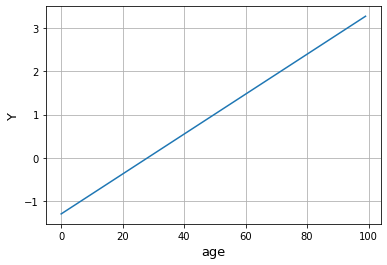

In [12]:
X3 = np.arange(0, 100)
Y_test = []
for x3 in X3:
    y = -1.3*1 + 2.6*0 + 0.0462*x3
    Y_test.append(y)

plt.plot(Y_test)
plt.xlabel("age", size=13)
plt.ylabel("Y", size=13)
plt.grid()
plt.show()

↑↑ 30手前くらいまでYがマイナスになる

### 11.3.1　解析の目的とデータ分布の確認

- リピーターになりそうな人を知りたい
- 説明変数でリピーターになるかをどれほど予測できるか知りたい
- それぞれの説明変数がリピーターになるかにどれほど影響しているか知りたい

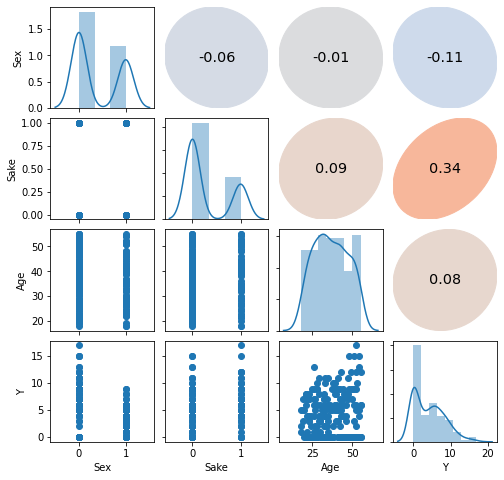

In [14]:
pairplot(df, corr_kws=dict(correlation="spearman"))

- 女性が少し少ない
- お酒を飲む人が少ない
- 年齢は一様分布に近い
- 来店回数は0が突出して多く、0以外は山型の分布
- 女性だと来店回数が少ない
- 年齢が高くなると少し来店回数が増えそうに見えるが、来店回数0に引っ張られてか順位相関係数は小さい


### 11.3.2 メカニズムの想像

- 「とにかく一回足を運んで来店すること」と「その店を気に入ってリピーターになって複数回来店すること」は別だと考える
- 一回来店するのは来店確率q のベルヌーイ分布に従う
- リピーターの来店回数は平均λのポアソン分布に従うと考える
- qにはロジスティック回帰を、λにはポアソン回帰をして、説明変数の影響を分けて推定する


- コイントスで裏が出るか表が出るか（ベルヌーイ分布で0が出るか1が出るか）は離散パラメータになる
- これをStanで実装するには周辺化消去する必要がある
- 来店回数は次の式で表現できる

$$
ZIP(y|q,\lambda) = 
  \begin{cases}
    Bernoulli(0|q) + Bernoulli(1|q) * Poisson(y=0|\lambda) \quad if \ y=0 \\
    \qquad \qquad \qquad \quad \ \ 
                     Bernoulli(1|q) * Poisson(y|\lambda)\qquad \quad if \ y\ge 1
  \end{cases}
$$

### 11.3.3 モデル式の記述

モデル式にすると以下のようになる

■モデル式11-7■

$$
\begin{align}
  q[n] &= inv\_logit((\bold{X}\vec{b_1})[n]) \qquad \qquad n = 1,...,N\\
  \lambda[n] &= (\bold{X}\vec{b_1})[n] \qquad \qquad \qquad \qquad \quad n = 1,...,N \\
  Y[n] &\sim ZIP(q[n], \lambda[n]) \qquad \qquad \qquad n = 1,...,N
\end{align}
$$

- N : 人数
- $\bold{X}$ : N行(1+3)列の行列。「切片項」と「各説明変数」のデータ。
- $\vec{b}$ : 回帰係数。上記同様、長さ4のベクトル。

### 11.3.4 Stanで実装

In [30]:
stan_model = """
functions {
    real ZIP_lpmf(int Y, real q, real lambda) {
        if (Y == 0) {
            return log_sum_exp(
                bernoulli_lpmf(0 | q),
                bernoulli_lpmf(1 | q) + poisson_log_lpmf(0 | lambda)
            );
        } else {
            return bernoulli_lpmf(1 | q) + poisson_log_lpmf(Y | lambda);
        }
    }
}

data {
    int N;
    int D;
    int<lower=0> Y[N];
    matrix[N, D] X;
}

parameters {
    vector[D] b[2];
}

transformed parameters {
    vector[N] q_x;
    vector[N] q;
    vector[N] lambda;

    q_x = X*b[1];
    lambda = X*b[2];
    for (n in 1:N) {
        q[n] = inv_logit(q_x[n]);
    }
}

model {
    for (n in 1:N) {
        Y[n] ~ ZIP(q[n], lambda[n]);
    }
}
"""

columns = ["Const"] + df.drop("Y", axis=1).columns.to_list()
X = pd.DataFrame(X, columns=columns)  # statsmodelsの時のXを再利用
X["Age"] /= 10  # スケーリング
display(X.head())
X = X.values

stan_data = {
    "N": len(df),                             # 200
    "D": 1 + df.drop("Y", axis=1).shape[-1],  # 4
    "Y": Y,
    "X": X,
}

posterior = stan.build(stan_model, data=stan_data, random_seed=123)
fit = posterior.sample()
fit.to_frame().describe()

,Const,Sex,Sake,Age
0,1.0,0.0,1.0,0.18
1,1.0,1.0,0.0,0.18
2,1.0,1.0,1.0,0.18
3,1.0,0.0,0.0,0.19
4,1.0,0.0,0.0,0.19


Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_y3sj8_jr/model_vhc47glt.stan', line 18, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/tmp/httpstan_y3sj8_jr/model_vhc47glt.stan', line 23, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Sampling:   0%
Sampling:   0% (1/8000)
Sampling:   0% (2/8000)
Sampling:   0% (3/8000)
Sampling:   0% (4/8000)
Sampling:   1% (103/8000)
Sampling:   3% (202/8000)
Sampling:   4% (301/8000)
Sampling:   5% (400/8000)
Sampling:   9% (700/8000)
Sampling:  11% (900/8000)
Sampling:  15% (1200/8000)
Samplin

parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,b.1.1,b.2.1,b.1.2,b.2.2,b.1.3,b.2.3,b.1.4,b.2.4,q_x.1,q_x.2,q_x.3,q_x.4,q_x.5,q_x.6,q_x.7,q_x.8,q_x.9,q_x.10,...,lambda.176,lambda.177,lambda.178,lambda.179,lambda.180,lambda.181,lambda.182,lambda.183,lambda.184,lambda.185,lambda.186,lambda.187,lambda.188,lambda.189,lambda.190,lambda.191,lambda.192,lambda.193,lambda.194,lambda.195,lambda.196,lambda.197,lambda.198,lambda.199,lambda.200
count,4000.000000,4000.000000,4000.000000,4000.0000,4000.000000,4000.0,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,...,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,-399.684103,0.920499,0.170692,4.3915,24.881000,0.0,403.685640,0.960571,1.449436,1.615846,-0.747070,3.371957,-0.162998,-3.717801,1.982324,3.663324,1.907213,5.279170,0.254188,0.254188,1.870035,3.588968,0.217010,0.179832,0.179832,...,1.550354,1.713352,2.460421,2.460421,1.713352,2.317247,1.570177,2.317247,1.733175,2.317247,1.733175,2.500068,2.500068,2.337070,2.519891,1.772821,2.519891,1.609823,1.772821,2.519891,2.376716,2.539714,2.539714,2.376716,1.792645
std,2.030589,0.093134,0.018217,0.6110,8.232787,0.0,2.820829,0.693518,0.133172,0.432633,0.080363,0.831016,0.075691,1.847682,0.334760,0.896334,0.524841,1.050302,0.382304,0.382304,0.511120,0.878679,0.367917,0.353909,0.353909,...,0.091892,0.083833,0.076390,0.076390,0.083833,0.066163,0.093108,0.066163,0.085811,0.066163,0.085811,0.080973,0.080973,0.068110,0.083372,0.090008,0.083372,0.095845,0.090008,0.083372,0.072312,0.085835,0.085835,0.072312,0.092218
min,-412.756744,0.332684,0.154436,2.0000,3.000000,0.0,396.815692,-1.275724,0.999306,0.391069,-1.061975,1.447514,-0.451593,-11.338700,0.800537,1.349662,0.336693,2.681573,-0.949182,-0.949182,0.342930,1.316645,-0.932476,-0.958375,-0.958375,...,1.210427,1.398006,2.187922,2.187922,1.398006,2.055330,1.233982,2.055330,1.414167,2.055330,1.414167,2.210267,2.210267,2.064263,2.221439,1.446488,2.221439,1.277413,1.446488,2.221439,2.082130,2.232612,2.232612,2.082130,1.462648
25%,-400.846737,0.883820,0.160058,4.0000,15.000000,0.0,401.654524,0.493287,1.358818,1.317757,-0.800921,2.818854,-0.212985,-4.972528,1.758787,3.039544,1.539267,4.553181,-0.003740,-0.003740,1.513958,2.977368,-0.029756,-0.056455,-0.056455,...,1.489356,1.656333,2.409285,2.409285,1.656333,2.272011,1.508375,2.272011,1.674821,2.272011,1.674821,2.445551,2.445551,2.291176,2.464488,1.710984,2.464488,1.545289,1.710984,2.464488,2.327466,2.482506,2.482506,2.327466,1.729290
50%,-399.367945,0.955493,0.163393,4.0000,31.000000,0.0,403.343464,0.961369,1.449216,1.603512,-0.747865,3.278384,-0.162361,-3.735308,1.981317,3.588812,1.899092,5.192684,0.256804,0.256804,1.864200,3.513227,0.217113,0.178926,0.178926,...,1.552776,1.713515,2.459124,2.459124,1.713515,2.317686,1.572486,2.317686,1.732992,2.317686,1.732992,2.499095,2.499095,2.337716,2.519507,1.773139,2.519507,1.611230,1.773139,2.519507,2.376263,2.539069,2.539069,2.376263,1.792849
75%,-398.203407,0.989541,0.174028,5.0000,31.000000,0.0,405.351125,1.430623,1.539982,1.904437,-0.692774,3.807603,-0.110844,-2.450869,2.212381,4.172999,2.241943,5.891414,0.511254,0.511254,2.194000,4.084548,0.466345,0.418955,0.418955,...,1.612657,1.769882,2.513077,2.513077,1.769882,2.361572,1.632972,2.361572,1.790957,2.361572,1.790957,2.555860,2.555860,2.383172,2.577538,1.833386,2.577538,1.673452,1.833386,2.577538,2.425951,2.598977,2.598977,2.425951,1.854699
max,-395.832120,1.000000,0.201547,5.0000,63.000000,0.0,417.816602,3.608428,1.956851,3.890841,-0.464272,7.438832,0.100922,2.262911,3.018058,8.107774,3.860185,10

- 来店確率は「女性でお酒を飲んで年齢が低い人」が高い
- リピーターになる確率は「男性でお酒を飲まなくて年齢が高い人」が高い
- 来店確率とリピーターとなる確率は大きな負の相関になる

## 11.4 Latent Dirichlet Allocation

あるスーパーマーケットのネットショップにおいて、顧客がどの商品を購入したかを記録した架空データを扱う。

In [31]:
df_lda = pd.read_csv("./data/data-lda.txt")
df_lda.head()

,PersonID,ItemID
0,1,105
1,1,80
2,1,54
3,1,120
4,1,6


In [32]:
df_lda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1117 entries, 0 to 1116
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   PersonID  1117 non-null   int64
 1   ItemID    1117 non-null   int64
dtypes: int64(2)
memory usage: 17.6 KB


- 顧客数は50人
- 商品数は120個

### 11.4.1 解析の目的とデータの分布の確認

解析の目的

- 購入履歴から顧客の特徴を抽出したい
- 商品をグルーピングしたい

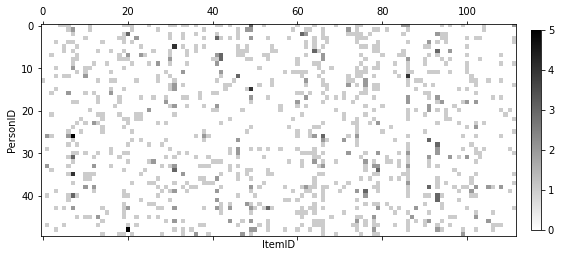

In [34]:
"""
商品×顧客のクロス集計表。購入回数に応じて着色している（回数が多いほど黒色）
→ 白が多い
"""
im = plt.matshow(pd.crosstab(df_lda['PersonID'], df_lda['ItemID']), cmap='binary', aspect='equal')
plt.colorbar(im, fraction=0.02, pad=0.03)
plt.setp(plt.gca(), xlabel='ItemID', ylabel='PersonID')
plt.show()

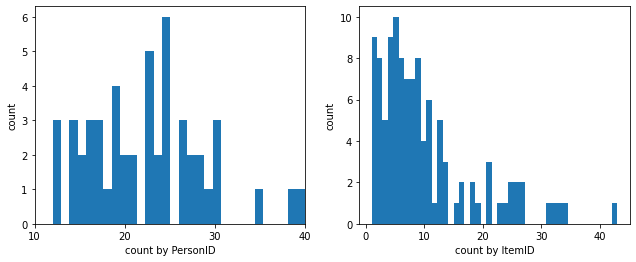

In [37]:
"""
左：顧客ごとの購入回数のヒストグラム → 顧客による大きな差はない
右：商品ごとの購入回数のヒストグラム → 商品によって大きな差がある
"""
_, (ax1, ax2) = plt.subplots(1, 2, figsize=figaspect(3/8))
ax1.hist(df_lda.groupby('PersonID').count().unstack(), bins=30)
plt.setp(ax1, xticks=np.arange(10, 41, 10), xlim=(10, 40), xlabel='count by PersonID', ylabel='count')
ax2.hist(df_lda.groupby('ItemID').count().unstack(), bins=45)
plt.setp(ax2, xlabel='count by ItemID', ylabel='count')
plt.show()

- 購入データにおいては、ごく一部の顧客が他の人があまり買わないようなマニアックな商品を気に入り、細々と購入し続けることも多い
- このようなデータに主成分分析を実行すると、そのごく一部のデータが失われてしまう
- LDAではこのような情報も活用できる

### 11.4.2 メカニズムの想像

ここではK=6個のタグで顧客を特徴づけることを考える。

タグは下記とする。
1. 生鮮食品
1. 保存食品
1. 日用品
1. 衣料
1. 健康美容品
1. 飲料

- ある顧客が商品を購入する際には、上記タグの6面サイコロを振る（それぞれの面の出る確率は顧客ごとに異なる）
- タグ毎に特化した120面サイコロを振る（例えば、飲料タグの場合は緑茶などの飲料が出やすい120面サイコロを振る）

→ 顧客ごとの6面サイコロの各面の出現確率を推定する。

例）サラリーマンは「健康美容品」の確率は低め、主婦は「生鮮食品」の確率が高い、と判断できる

- LDAは120個の商品の勾配情報から6個の成分のバランスに情報を圧縮すると解釈できる
- さらに、タグに特化した120面サイコロの各面の出現確率も推定する
- すると、どの商品が出やすいかでタグを特徴づけることができる

![](./data/11-9.jpg)

参考）

[確率思考の戦略論 USJでも実証された数学マーケティングの力](https://www.amazon.co.jp/dp/4041041422)

- あるカテゴリーにおける消費者のブランド選択は、プレファレンスによって定まる確率に従い、それはカテゴリーの平均購入回数の多い少ないには関係がない。
- 消費者の頭の中には、今までの購入経験から、購入候補であるいくつかのブランドの組み合わせ（Evoked Set）がある。このエボークトセットの中からプレファレンスに基づいて購入確率が決まる。

※プレファレンスとは、消費者のブランドに対する相対的な好意度（簡単に言えば好み）。主にブランドエクイティー、価格、製品パフォーマンスの３つによって決定されている。

ただし、

- これまでは説明のためタグの内容を「生鮮食品」などあらかじめ与えたが、本来は逆である
- 例えば、推定された出やすいトップ20の商品名から「このタグは生鮮食品である」と解釈する必要がある
- タグの数は複数試して十分な大きさに指定しておく必要がある
- タグの数が少ないと、例えば「日用品」と「衣料」が分離できずに一緒のタグとして推定されてしまう
- 高度なモデル（ノンパラメトリックベイズモデル）においては、タグの数すらも推定することができる（本書の範囲を超えるため割愛）

### 11.4.3 モデル式の記述

$$
\begin{align}
  dice &\sim Categorical(\vec{\theta[n]}) \\
  y &\sim Categorical(\vec{\phi[dice]})
\end{align}
$$

- $\vec{\theta}$ : 長さK（タグ数）のベクトル
- $\vec{\phi}$ : 長さI（アイテム数）のベクトル

![](./data/11-10.jpg)

n番目の顧客がy番目の商品を購入する確率分布は次のように表せる

$$
\begin{align}
  p(y| \vec{\theta[n]}, \vec{\phi[1]}, ..., \vec{\phi[K]})
  &= \sum_{k=1}^{K} [Categorical(k|\vec{\theta[n]}) × Categorical(y|\vec{\phi[k]})] \\
  &= \sum_{k=1}^{K} [\theta[n, k] × \phi[k, y]]
\end{align}
$$

- nで決まるK面サイコロ$\vec{\theta[n]}$ と、K個のI面サイコロ$\vec{\phi[1]}, ..., \vec{\phi[K]}$ を与えたときに、yを生成する確率分布になっている
- この分布を仮に「CateCate分布」と呼ぶ
- このCateCate分布を使うと、今回のデータファイルを1行ずつ独立に生成するモデル式は以下のように表現できる

■ モデル式11-8 ■

$$
  ItemID[e] \sim CateCate(\vec{\theta[PersonID[e]]}, \vec{\phi[1]}, ..., \vec{\phi[K]}) \quad e=1,...,E
$$

- Eは全購入イベント数、eはイベントのインデックスを表す
- N個のK面サイコロとK個のI面サイコロの各面の出現確率をデータから推定する
- パラメータに制約がないとうまく推定できない場合がある
- その場合、弱情報事前分布を設定する
- 要素がすべて1.0以下である長さ$I$のベクトルを$\vec{a}$とし、$Dirichlet(\vec{a})$ を $\vec{\phi[k]}$ の弱情報事前分布として設定する

### 11.4.4 Rでシミュレーション

In [38]:

N = 50
I = 120
K = 6

np.random.seed(123)
alpha0 = np.full(K, 0.8)
alpha1 = np.full(I, 0.2)
theta = np.random.dirichlet(alpha0, N)  # PersonID毎のK面サイコロ
phi = np.random.dirichlet(alpha1, K)    # タグ毎の120面サイコロ

# イベント数Eを決める代わりに、顧客ごとの購入回数を対数正規分布で生成している
num_items_by_n = np.round(np.exp(np.random.normal(2.0, 0.5, N))).astype(int)

d = pd.DataFrame()
for n in range(N):
    z = np.random.choice(np.arange(K), num_items_by_n[n], replace=True, p=theta[n])
    item = [np.random.choice(np.arange(I), 1, replace=True, p=phi[k])[0] for k in z]
    d = d.append(pd.DataFrame(dict(PersonID=np.repeat(n, len(item)), ItemID=item)))

### 11.4.5 Stanで実装

In [47]:
stan_model = """
functions {
    real CateCate_lpmf(int Y, int K, vector theta, vector[] phi) {
        vector[K] lp;
        for (k in 1:K) {
            lp[k] = log(theta[k]) + log(phi[k, Y]);
        }
        return log_sum_exp(lp);
    }
}

data {
    int<lower=1> E;
    int<lower=1> N;
    int<lower=1> I;
    int<lower=1> K;
    int<lower=1, upper=N> PersonID[E];
    int<lower=1, upper=I> ItemID[E];
    vector<lower=0>[I] Alpha;
}

parameters {
    simplex[K] theta[N];
    simplex[I] phi[K];
}

model {
    for (k in 1:K) {
        phi[k] ~ dirichlet(Alpha);
    }
    for (e in 1:E) {
        ItemID[e] ~ CateCate(K, theta[PersonID[e]], phi);
    }
}
"""

stan_data = {
    "E": len(df_lda),
    "N": 50,
    "I": 120,
    "K": 6,
    "PersonID": df_lda["PersonID"].values,
    "ItemID": df_lda["ItemID"].values,
    "Alpha": np.repeat(0.5, 120)
}

posterior = stan.build(stan_model, data=stan_data, random_seed=123)
fit = posterior.sample()
fit.to_frame().describe()

Building...

In file included from /usr/local/lib/python3.10/site-packages/httpstan/include/stan/model/model_header.hpp:7,
                 from /root/.cache/httpstan/4.7.1/models/llgdvn2q/model_llgdvn2q.cpp:2:
/usr/local/lib/python3.10/site-packages/httpstan/include/stan/io/dump.hpp: In member function ‘virtual std::vector<std::complex<double> > stan::io::dump::vals_c(const string&) const’:
/usr/local/lib/python3.10/site-packages/httpstan/include/stan/io/dump.hpp:694:52: warning: comparison of integer expressions of different signedness: ‘int’ and ‘std::vector<double, std::allocator<double> >::size_type’ {aka ‘long unsigned int’} [-Wsign-compare]
  694 |       for (comp_iter = 0, real_iter = 0; real_iter < val_r->second.first.size();
      |                                          ~~~~~~~~~~^~~~~~~~~~~~~~~~~~~~~~~~~~~~
/usr/local/lib/python3.10/site-packages/httpstan/include/stan/io/dump.hpp:707:24: warning: comparison of integer expressions of different signedness: ‘int’ and ‘std::vector<int>::s


Building: 30.4s, done.Messages from stanc:
Warning in '/tmp/httpstan_msl_q316/model_llgdvn2q.stan', line 3, column 51: Declaration
    of arrays by placing brackets after a type is deprecated and will be
    removed in Stan 2.32.0. Instead use the array keyword before the type.
    This can be changed automatically using the auto-format flag to stanc
Warning in '/tmp/httpstan_msl_q316/model_llgdvn2q.stan', line 17, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/tmp/httpstan_msl_q316/model_llgdvn2q.stan', line 18, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc


parameters,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,theta.1.1,theta.2.1,theta.3.1,theta.4.1,theta.5.1,theta.6.1,theta.7.1,theta.8.1,theta.9.1,theta.10.1,theta.11.1,theta.12.1,theta.13.1,theta.14.1,theta.15.1,theta.16.1,theta.17.1,theta.18.1,...,phi.6.116,phi.1.117,phi.2.117,phi.3.117,phi.4.117,phi.5.117,phi.6.117,phi.1.118,phi.2.118,phi.3.118,phi.4.118,phi.5.118,phi.6.118,phi.1.119,phi.2.119,phi.3.119,phi.4.119,phi.5.119,phi.6.119,phi.1.120,phi.2.120,phi.3.120,phi.4.120,phi.5.120,phi.6.120
count,4000.000000,4000.000000,4000.000000,4000.0,4000.0,4000.0,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,...,4.000000e+03,4.000000e+03,4.000000e+03,4.000000e+03,4.000000e+03,4.000000e+03,4.000000e+03,4.000000e+03,4.000000e+03,4.000000e+03,4.000000e+03,4.000000e+03,4.000000e+03,4.000000e+03,4.000000e+03,4.000000e+03,4.000000e+03,4.000000e+03,4.000000e+03,4.000000e+03,4.000000e+03,4.000000e+03,4.000000e+03,4.000000e+03,4.000000e+03
mean,-7797.616884,0.873266,0.071320,6.0,63.0,0.0,8279.471122,0.168342,0.165240,0.162157,0.169114,0.165912,0.170329,0.164479,0.164956,0.166426,0.169189,0.168874,0.166645,0.162722,0.168366,0.171765,0.172436,0.164740,0.161800,...,8.096489e-03,2.848446e-03,2.805344e-03,2.821218e-03,2.712179e-03,2.709630e-03,2.774959e-03,2.065071e-03,2.033778e-03,2.024157e-03,2.034197e-03,1.988315e-03,1.986273e-03,4.073428e-03,4.214533e-03,3.970241e-03,4.039351e-03,4.203256e-03,4.155471e-03,1.027737e-02,1.072495e-02,1.026470e-02,9.864081e-03,9.675210e-03,9.848294e-03
std,25.972549,0.108869,0.001712,0.0,0.0,0.0,34.520944,0.132862,0.139308,0.143018,0.132315,0.132572,0.145783,0.140046,0.145185,0.141005,0.132596,0.137903,0.136247,0.149882,0.135800,0.149137,0.176742,0.136492,0.134849,...,9.479130e-03,3.942179e-03,3.756100e-03,3.932025e-03,3.638127e-03,3.701076e-03,3.682016e-03,2.932803e-03,2.959961e-03,3.001104e-03,2.829183e-03,2.826281e-03,2.928710e-03,5.047752e-03,5.326829e-03,5.120465e-03,5.192142e-03,5.291411e-03,5.406134e-03,1.182849e-02,1.211788e-02,1.198797e-02,1.124106e-02,1.123042e-02,1.160626e-02
min,-7888.949970,0.321213,0.068867,6.0,63.0,0.0,8144.791857,0.000007,0.000021,0.000042,0.000061,0.000037,0.000065,0.000067,0.000034,0.000002,0.000175,0.000063,0.000116,0.000011,0.000046,0.000001,0.000085,0.000027,0.000132,...,3.562478e-09,1.039109e-10,6.287525e-10,2.640371e-11,6.220257e-10,7.083864e-12,1.650475e-11,7.986847e-11,1.049513e-10,3.397594e-15,9.996435e-10,4.093625e-10,4.676565e-10,7.958231e-10,4.233591e-10,1.548462e-11,2.424323e-11,6.480105e-12,2.503941e-10,3.443756e-08,7.676985e-11,9.482101e-09,5.946436e-09,4.089997e-11,2.227147e-10
25%,-7815.311843,0.808859,0.070361,6.0,63.0,0.0,8255.240676,0.064051,0.054908,0.049469,0.063704,0.062261,0.054753,0.053089,0.051694,0.055687,0.063394,0.060086,0.059882,0.048827,0.060215,0.053990,0.041669,0.058514,0.056463,...,1.139799e-03,2.814828e-04,2.855142e-04,3.071217e-04,2.652178e-04,3.087281e-04,2.904105e-04,2.281101e-04,1.867359e-04,1.821059e-04,2.546864e-04,1.973613e-04,1.966815e-04,4.983545e-04,4.920913e-04,4.793717e-04,4.812135e-04,5.045209e-04,4.845755e-04,1.408504e-03,1.512900e-03,1.419767e-03,1.386331e-03,1.352665e-03,1.207537e-03
50%,-7797.149713,0.903823,0.071422,6.0,63.0,0.0,8278.675106,0.137283,0.129417,0.121474,0.138362,0.135022,0.129005,0.127608,0.122728,0.130667,0.139817,0.135246,0.131644,0.114728,0.135813,0.130693,0.107525,0.130165,0.125244,...,4.546418e-03,1.322295e-03,1.334357e-03,1.372303e-03,1.262427e-03,1.298176e-03,1.300048e-03,9.475991e-04,8.846556e-04,8.494003e-04,9.791601e-04,8.588395e-04,8.827090e-04,2.131228e-03,2.253791e-03,2.071430e-03,2.138036e-03,2.228025e-03,2.043726e-03,5.862793e-03,6.369539e-03,6.059207e-03,5.618718e-03,5.540920e-03,5.573285e-03
75%,-7780.084600,0.960334,0.072380,6.0,63.0,0.0,8303.421792,0.242316,0.239679,0.234719,0.241490,0.23

NUTSでは時間がかかるため、変分ベイズ法を用いたADVIを利用する

※NUTSによる推定では、ラベルスイッチングが起こるため識別可能になるように何らかの制約が必要

In [48]:
stan_model = """
functions {
    real CateCate_lpmf(int Y, int K, vector theta, vector[] phi) {
        vector[K] lp;
        for (k in 1:K) {
            lp[k] = log(theta[k]) + log(phi[k, Y]);
        }
        return log_sum_exp(lp);
    }
}

data {
    int<lower=1> E;
    int<lower=1> N;
    int<lower=1> I;
    int<lower=1> K;
    int<lower=1, upper=N> PersonID[E];
    int<lower=1, upper=I> ItemID[E];
    vector<lower=0>[I] Alpha;
}

parameters {
    simplex[K] theta[N];
    simplex[I] phi[K];
}

model {
    for (k in 1:K) {
        phi[k] ~ dirichlet(Alpha);
    }
    for (e in 1:E) {
        ItemID[e] ~ CateCate(K, theta[PersonID[e]], phi);
    }
}
"""

stan_data = {
    "E": len(df_lda),
    "N": 50,
    "I": 120,
    "K": 6,
    "PersonID": df_lda["PersonID"].values,
    "ItemID": df_lda["ItemID"].values,
    "Alpha": np.repeat(0.5, 120)
}

posterior = stan.build(stan_model, data=stan_data, random_seed=123)
fit = posterior.vb()
fit.to_frame().describe()

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_msl_q316/model_llgdvn2q.stan', line 3, column 51: Declaration
    of arrays by placing brackets after a type is deprecated and will be
    removed in Stan 2.32.0. Instead use the array keyword before the type.
    This can be changed automatically using the auto-format flag to stanc
Warning in '/tmp/httpstan_msl_q316/model_llgdvn2q.stan', line 17, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in '/tmp/httpstan_msl_q316/model_llgdvn2q.stan', line 18, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.32.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
 

AttributeError: 'Model' object has no attribute 'vb'

- タグごとに商品の出現確率を描画すると下記のようになる
- ある商品で特徴づけられたタグもあれば、特徴がないタグもある（余裕をもってＫを指定したため）
- 顧客のタグの出現確率にも差がある（この値を使った顧客をサブグループに分けることも可能）

![](./data/11.11.jpg)

- LDAのオリジナルの論文は自然言語処理におけるもの。
- 顧客が文書、商品が単語に相当し、タグが「トピック」に該当する
- LDAは文書からトピックを抽出する「トピックモデル」の一種
- LDAを高速に実行できるライブラリは様々あるが、これを拡張することは困難。しかし、Stanであれば拡張可能。